In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
dist_corner = np.loadtxt("CustDist_WHcorner.csv", skiprows=1, delimiter=",")[:,1:]
xy_corner   = np.loadtxt("CustXY_WHcorner.csv", skiprows=1, delimiter=",")[:,1:].T

dist_corner  = np.loadtxt("CustDist_WHCorner.csv", skiprows=1, delimiter=",")[:,1:]
xy_corner    = np.loadtxt("CustXY_WHCorner.csv", skiprows=1, delimiter=",")[:,1:].T

orders       = np.loadtxt("CustOrd.csv", skiprows=1, delimiter=",")[:,1:]

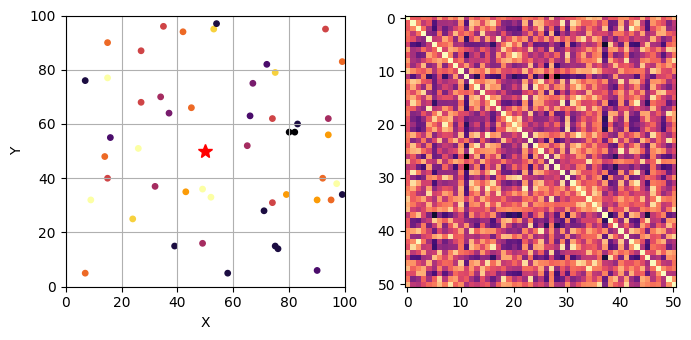

In [53]:
fig, ax = plt.subplots(ncols=2, figsize=(7,3.5))

ax[0].set(xlabel="X", ylabel="Y", xlim=(0,100), ylim=(0,100))

ax[0].scatter(xy_corner[0][1:], xy_corner[1][1:], marker="o", s=15, c=orders[1:], cmap="inferno_r")
ax[0].plot(xy_corner[0][0], xy_corner[1][0], ls="", marker="*", ms=10, c="red")
ax[0].grid()

im = ax[1].imshow(dist_corner, cmap="magma_r")
# fig.colorbar(im, ax=ax[1])#, label='Interactive colorbar')
plt.tight_layout()

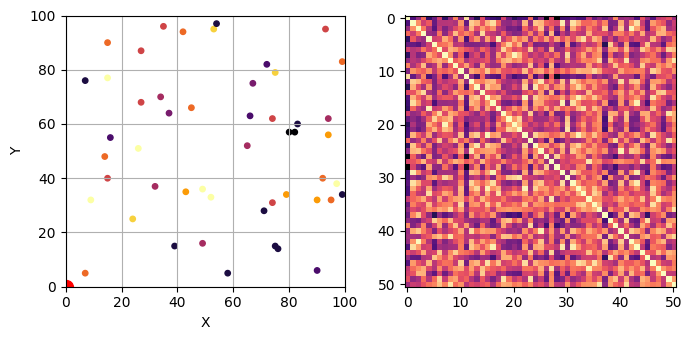

In [58]:
fig, ax = plt.subplots(ncols=2, figsize=(7,3.5))

ax[0].set(xlabel="X", ylabel="Y", xlim=(0,100), ylim=(0,100))

ax[0].scatter(xy_corner[0][1:], xy_corner[1][1:], marker="o", s=15, c=orders[1:], cmap="inferno_r")
ax[0].plot(xy_corner[0][0], xy_corner[1][0], ls="", marker="o", ms=10, c="red")
ax[0].grid()

im = ax[1].imshow(dist_corner, cmap="magma_r")
# fig.colorbar(im, ax=ax[1])#, label='Interactive colorbar')
plt.tight_layout()